In [2]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt

from PIL import Image
from torchsummary import summary
from fastprogress import progress_bar

od.download("https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small")

Skipping, found downloaded files in "./fashion-product-images-small" (use force=True to force download)


In [3]:
class FashionDataset(torch.utils.data.Dataset):
    def __init__(self, root="fashion-product-images-small", size=(64, 64)):
        metadata = pd.read_csv(os.path.join(root, "styles.csv"), on_bad_lines='skip')
        # check if images exist
        metadata['exists'] = metadata['id'].apply(lambda id: os.path.exists(os.path.join(root, "images", f"{id}.jpg")))
        metadata = metadata[metadata['exists']]
        # extract classes
        classes = metadata[['masterCategory', 'subCategory']].values
        classes = np.reshape(classes, (-1)).tolist()
        classes = list(set(classes))
        self.classes = { category: idx  for idx, category in enumerate(classes) }
        # extract image file names
        self.image_files = metadata['id'].apply(lambda id: os.path.join(root, "images", f"{id}.jpg")).values
        # extract image labels
        image_labels = []
        for _, row in metadata[['masterCategory', 'subCategory']].iterrows():
            image_labels.append(np.array([self.classes[data] for data in row], dtype=np.int64))
        self.image_labels = np.array(image_labels)
        # image size
        self.size = size
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # image label
        label = torch.tensor(self.image_labels[idx], dtype=torch.int64)
        # load image file
        image = Image.open(self.image_files[idx]).convert('RGB')
        image = image.resize(self.size)
        image = np.array(image)
        # format to (channel, width, height)
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        # normalize image
        image = (image / 127.5) - 1

        return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


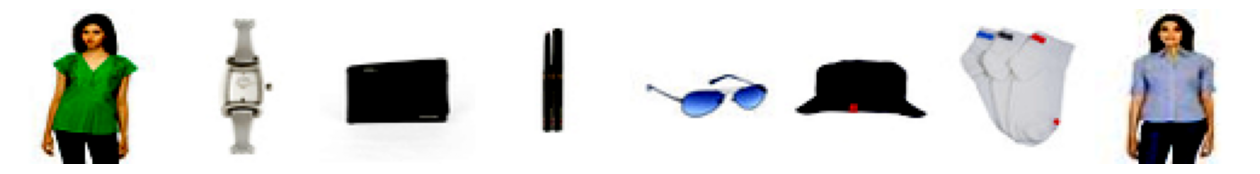

In [5]:
# load dataset
train_dataset = FashionDataset(root="fashion-product-images-small", size=(64, 64))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# extract a batch of images
batch_images, batch_labels = next(iter(train_loader))
# display a grid of images
plt.figure(figsize=(16, 12))
plt.imshow(np.transpose(torchvision.utils.make_grid(batch_images[:8], padding=0).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

#### Attention Block

In [6]:
class SelfAttention(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.mha = torch.nn.MultiheadAttention(channels, num_heads=1, batch_first=True)
        self.ln = torch.nn.LayerNorm([channels])
        self.ff_self = torch.nn.Sequential(
            torch.nn.LayerNorm([channels]),
            torch.nn.Linear(channels, channels),
            torch.nn.GELU(),
            torch.nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)

#### Residual Block

In [7]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.group_norm_1 = torch.nn.GroupNorm(32, in_channels)
        self.conv_1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.group_norm_2 = torch.nn.GroupNorm(32, out_channels)
        self.conv_2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = torch.nn.Identity()
        else:
            self.residual_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        residue = x

        x = self.group_norm_1(x)
        x = torch.nn.functional.silu(x)
        x = self.conv_1(x)

        x = self.group_norm_2(x)
        x = torch.nn.functional.silu(x)
        x = self.conv_2(x)

        return x + self.residual_layer(residue)

#### Encoder

In [12]:
class Encoder(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            # output: 64 x 64 x 64
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            ResidualBlock(64, 64),
            # output: 128 x 32 x 32
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
            ResidualBlock(128, 128),
            # output: 256 x 16 x 16
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0),
            ResidualBlock(256, 256),
            SelfAttention(256),
            ResidualBlock(256, 256),
            torch.nn.GroupNorm(32, 256),
            torch.nn.SiLU(),
            torch.nn.Conv2d(256, 8, kernel_size=3, padding=1),
            torch.nn.Conv2d(8, 8, kernel_size=1, padding=0)
        )

    def forward(self, x):
        for module in self:
            if getattr(module, 'stride', None) == (2, 2):
                x = torch.nn.functional.pad(x, (0, 1, 0, 1))
            x = module(x)

        mean, log_variance = torch.chunk(x, 2, dim=1)
        log_variance = torch.clamp(log_variance, -30, 20)
        variance = log_variance.exp()
        stdev = variance.sqrt()
        noise = torch.randn(*mean.size()).float().cuda()
        x = mean + stdev * noise

        x *= 0.18215
        return mean, log_variance, x

In [13]:
encoder = Encoder().float().cuda()
z_mean, z_log_var, z = encoder(torch.rand((8, 3, 64, 64)).float().cuda())

print('Latent space shape', z_mean.shape)

Latent space shape torch.Size([8, 4, 16, 16])


In [14]:
summary(encoder, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
         GroupNorm-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,928
         GroupNorm-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,928
          Identity-6           [-1, 64, 64, 64]               0
     ResidualBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
         GroupNorm-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 128, 32, 32]         147,584
        GroupNorm-11          [-1, 128, 32, 32]             256
           Conv2d-12          [-1, 128, 32, 32]         147,584
         Identity-13          [-1, 128, 32, 32]               0
    ResidualBlock-14          [-1, 128,

#### Decoder

In [15]:
class Decoder(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            torch.nn.Conv2d(4, 4, kernel_size=1, padding=0),
            torch.nn.Conv2d(4, 256, kernel_size=3, padding=1),
            ResidualBlock(256, 256),
            SelfAttention(256),
            ResidualBlock(256, 256),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(256, 128, kernel_size=3, padding=1),
            ResidualBlock(128, 128),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(128, 64, kernel_size=3, padding=1),
            ResidualBlock(64, 64),
            torch.nn.GroupNorm(32, 64),
            torch.nn.SiLU(),
            torch.nn.Conv2d(64, 3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x /= 0.18215
        for module in self:
            x = module(x)
        return x

In [16]:
decoder = Decoder().float().cuda()
reconstruction = decoder(torch.rand((8, 4, 16, 16)).float().cuda())

print('Reconstruction shape', reconstruction.shape)

Reconstruction shape torch.Size([8, 3, 64, 64])


In [17]:
summary(decoder, input_size=(4, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 16, 16]              20
            Conv2d-2          [-1, 256, 16, 16]           9,472
         GroupNorm-3          [-1, 256, 16, 16]             512
            Conv2d-4          [-1, 256, 16, 16]         590,080
         GroupNorm-5          [-1, 256, 16, 16]             512
            Conv2d-6          [-1, 256, 16, 16]         590,080
          Identity-7          [-1, 256, 16, 16]               0
     ResidualBlock-8          [-1, 256, 16, 16]               0
         LayerNorm-9             [-1, 256, 256]             512
MultiheadAttention-10  [[-1, 256, 256], [-1, 256, 256]]               0
        LayerNorm-11             [-1, 256, 256]             512
           Linear-12             [-1, 256, 256]          65,792
             GELU-13             [-1, 256, 256]               0
           Linear-14           

In [19]:
EPOCHS = 50
LEARNING_RATE = 5e-3

def loss_fn(recon_x, x, mean, log_var):
    mse = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.mean(1 + log_var - torch.pow(mean, 2) - torch.exp(log_var))

    return mse + kld, mse, kld

def save_checkpoint(checkpoint_path="diffusion_vae"):
    torch.save(encoder.state_dict(), os.path.join(checkpoint_path, "encoder_ckpt.pt"))
    torch.save(decoder.state_dict(), os.path.join(checkpoint_path, "decoder_ckpt.pt"))

def load_checkpoint(checkpoint_path="diffusion_vae"):
    encoder.load_state_dict(torch.load(os.path.join(checkpoint_path, "encoder_ckpt.pt")))
    decoder.load_state_dict(torch.load(os.path.join(checkpoint_path, "decoder_ckpt.pt")))

def log_images():
    encoder.eval()
    decoder.eval()
    with torch.inference_mode():
        sample_images = batch_images.cuda()
        _, _, z = encoder(sample_images)
        reconstructed = decoder(z)
        reconstructed = (reconstructed.clamp(-1, 1) + 1) / 2
        reconstructed = (reconstructed * 255).type(torch.uint8)

    # display a reconstructed images
    plt.figure(figsize=(16, 12))
    plt.imshow(np.transpose(torchvision.utils.make_grid(reconstructed[:8], padding=0).cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE, eps=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS)

/opt/conda/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1/50 - total_loss: 4.29e+07, reconstruction_loss: 4.29e+07, kl_loss: 6.73e+02


Epoch 2/50 - total_loss: 1.32e+07, reconstruction_loss: 1.32e+07, kl_loss: 8.65e+02


Epoch 3/50 - total_loss: 6.54e+06, reconstruction_loss: 6.54e+06, kl_loss: 1.06e+03


Epoch 4/50 - total_loss: 5.14e+06, reconstruction_loss: 5.14e+06, kl_loss: 1.24e+03


Epoch 5/50 - total_loss: 3.56e+06, reconstruction_loss: 3.56e+06, kl_loss: 1.43e+03


Epoch 6/50 - total_loss: 2.99e+06, reconstruction_loss: 2.99e+06, kl_loss: 1.58e+03


Epoch 7/50 - total_loss: 2.67e+07, reconstruction_loss: 2.67e+07, kl_loss: 4.01e+04


Epoch 8/50 - total_loss: 2.18e+07, reconstruction_loss: 2.18e+07, kl_loss: 5.14e+04


Epoch 9/50 - total_loss: 1.75e+07, reconstruction_loss: 1.75e+07, kl_loss: 2.67e+04


Epoch 10/50 - total_loss: 1.49e+07, reconstruction_loss: 1.48e+07, kl_loss: 2.05e+04


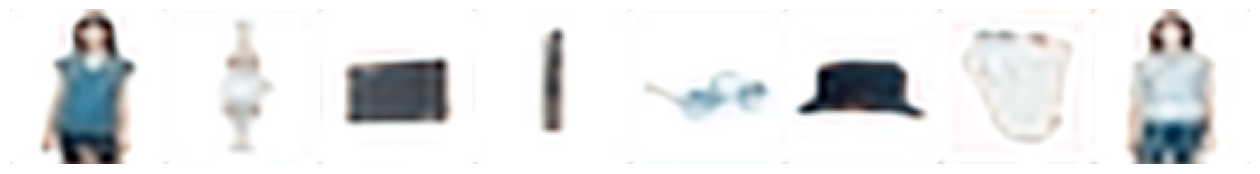

Epoch 11/50 - total_loss: 1.56e+07, reconstruction_loss: 1.56e+07, kl_loss: 2.06e+04


Epoch 12/50 - total_loss: 1.08e+07, reconstruction_loss: 1.08e+07, kl_loss: 2.52e+04


Epoch 13/50 - total_loss: 7.54e+06, reconstruction_loss: 7.52e+06, kl_loss: 1.90e+04


Epoch 14/50 - total_loss: 8.05e+06, reconstruction_loss: 8.03e+06, kl_loss: 2.19e+04


Epoch 15/50 - total_loss: 6.59e+06, reconstruction_loss: 6.57e+06, kl_loss: 1.92e+04


Epoch 16/50 - total_loss: 5.51e+06, reconstruction_loss: 5.50e+06, kl_loss: 1.56e+04


Epoch 17/50 - total_loss: 5.12e+06, reconstruction_loss: 5.10e+06, kl_loss: 1.53e+04


Epoch 18/50 - total_loss: 4.81e+06, reconstruction_loss: 4.79e+06, kl_loss: 1.37e+04


Epoch 19/50 - total_loss: 4.15e+06, reconstruction_loss: 4.14e+06, kl_loss: 1.21e+04


Epoch 20/50 - total_loss: 4.11e+06, reconstruction_loss: 4.10e+06, kl_loss: 1.12e+04


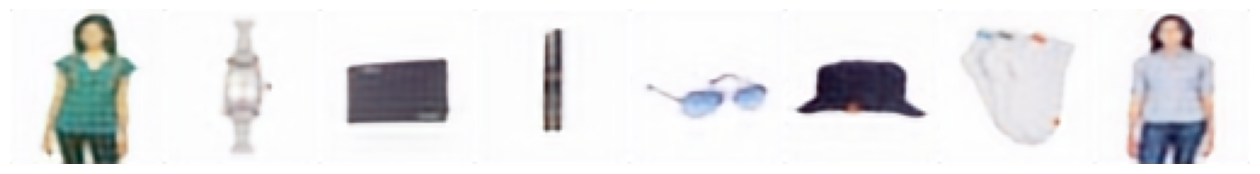

Epoch 21/50 - total_loss: 4.04e+06, reconstruction_loss: 4.03e+06, kl_loss: 1.04e+04


Epoch 22/50 - total_loss: 3.51e+06, reconstruction_loss: 3.50e+06, kl_loss: 8.47e+03


Epoch 23/50 - total_loss: 3.41e+06, reconstruction_loss: 3.40e+06, kl_loss: 7.52e+03


Epoch 24/50 - total_loss: 3.15e+06, reconstruction_loss: 3.14e+06, kl_loss: 6.42e+03


Epoch 25/50 - total_loss: 3.20e+06, reconstruction_loss: 3.19e+06, kl_loss: 6.35e+03


Epoch 26/50 - total_loss: 2.63e+06, reconstruction_loss: 2.63e+06, kl_loss: 5.38e+03


Epoch 27/50 - total_loss: 2.36e+06, reconstruction_loss: 2.36e+06, kl_loss: 4.87e+03


Epoch 28/50 - total_loss: 2.17e+06, reconstruction_loss: 2.17e+06, kl_loss: 4.55e+03


Epoch 29/50 - total_loss: 2.00e+06, reconstruction_loss: 2.00e+06, kl_loss: 4.11e+03


Epoch 30/50 - total_loss: 1.91e+06, reconstruction_loss: 1.91e+06, kl_loss: 3.80e+03


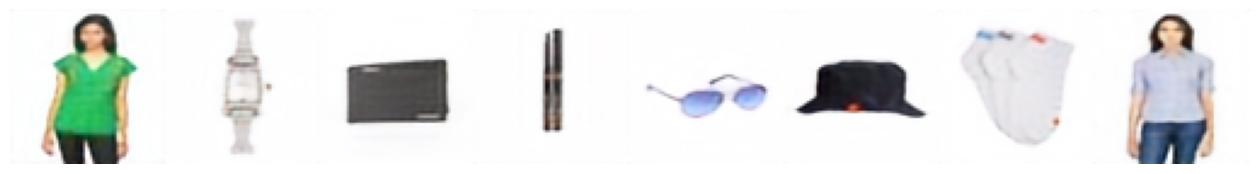

Epoch 31/50 - total_loss: 1.81e+06, reconstruction_loss: 1.80e+06, kl_loss: 3.55e+03


Epoch 32/50 - total_loss: 1.73e+06, reconstruction_loss: 1.72e+06, kl_loss: 3.35e+03


Epoch 33/50 - total_loss: 1.64e+06, reconstruction_loss: 1.64e+06, kl_loss: 3.08e+03


Epoch 34/50 - total_loss: 1.58e+06, reconstruction_loss: 1.57e+06, kl_loss: 2.86e+03


Epoch 35/50 - total_loss: 1.52e+06, reconstruction_loss: 1.52e+06, kl_loss: 2.70e+03


Epoch 36/50 - total_loss: 1.48e+06, reconstruction_loss: 1.47e+06, kl_loss: 2.54e+03


Epoch 37/50 - total_loss: 1.42e+06, reconstruction_loss: 1.41e+06, kl_loss: 2.39e+03


Epoch 38/50 - total_loss: 1.37e+06, reconstruction_loss: 1.37e+06, kl_loss: 2.25e+03


Epoch 39/50 - total_loss: 1.34e+06, reconstruction_loss: 1.34e+06, kl_loss: 2.16e+03


Epoch 40/50 - total_loss: 1.30e+06, reconstruction_loss: 1.29e+06, kl_loss: 2.04e+03


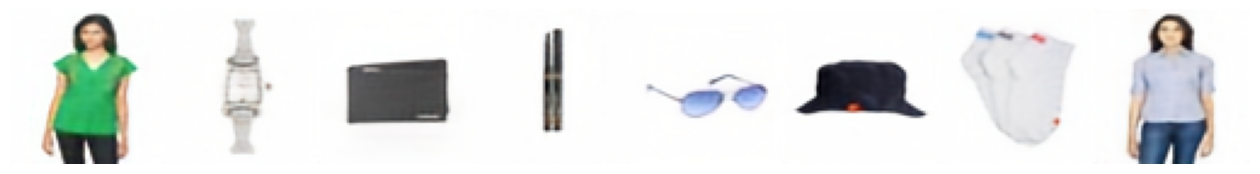

Epoch 41/50 - total_loss: 1.27e+06, reconstruction_loss: 1.27e+06, kl_loss: 1.95e+03


Epoch 42/50 - total_loss: 1.24e+06, reconstruction_loss: 1.24e+06, kl_loss: 1.89e+03


Epoch 43/50 - total_loss: 1.22e+06, reconstruction_loss: 1.22e+06, kl_loss: 1.83e+03


Epoch 44/50 - total_loss: 1.20e+06, reconstruction_loss: 1.20e+06, kl_loss: 1.78e+03


Epoch 45/50 - total_loss: 1.19e+06, reconstruction_loss: 1.18e+06, kl_loss: 1.75e+03


Epoch 46/50 - total_loss: 1.17e+06, reconstruction_loss: 1.17e+06, kl_loss: 1.72e+03


Epoch 47/50 - total_loss: 1.16e+06, reconstruction_loss: 1.16e+06, kl_loss: 1.70e+03


Epoch 48/50 - total_loss: 1.16e+06, reconstruction_loss: 1.16e+06, kl_loss: 1.69e+03


Epoch 49/50 - total_loss: 1.16e+06, reconstruction_loss: 1.15e+06, kl_loss: 1.68e+03


Epoch 50/50 - total_loss: 1.15e+06, reconstruction_loss: 1.15e+06, kl_loss: 1.68e+03


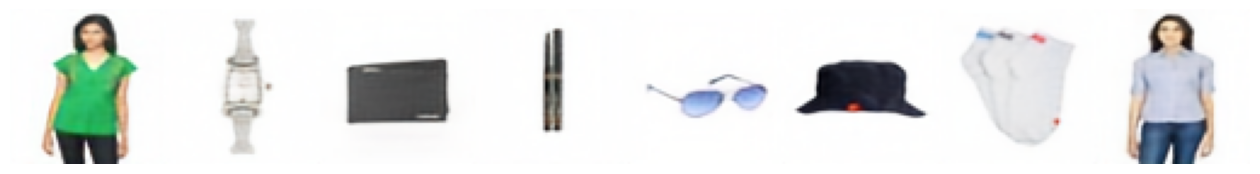

In [20]:
for epoch in range(EPOCHS):
    encoder.train()
    decoder.train()
    p_bar = progress_bar(train_loader, leave=False)
    avg_loss = 0.
    avg_kl_loss = 0.
    avg_reconstruction_loss = 0.
    for image, label in p_bar:
        image = image.cuda()
        with torch.autocast("cuda") and torch.enable_grad():
            # forward pass
            z_mean, z_log_var, z = encoder(image)
            reconstruction = decoder(z)
            # calculate loss
            loss, mse, kld = loss_fn(reconstruction, image, z_mean, z_log_var)
        # backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        # logger
        avg_loss += loss
        avg_kl_loss += kld
        avg_reconstruction_loss += mse
        p_bar.comment = f"total_loss: {loss.item():.2e}, reconstruction_loss: {mse.item():.2e}, kl_loss: {kld.item():.2e}"
    # log average loss
    print(f"Epoch {epoch + 1}/{EPOCHS} - total_loss: {avg_loss.mean().item():.2e}, reconstruction_loss: {avg_reconstruction_loss.mean().item():.2e}, kl_loss: {avg_kl_loss.mean().item():.2e}")
    
    if (epoch + 1) % 10 == 0:
        # view reconstructed images
        log_images()
        # save checkpoint
        save_checkpoint("diffusion_vae")

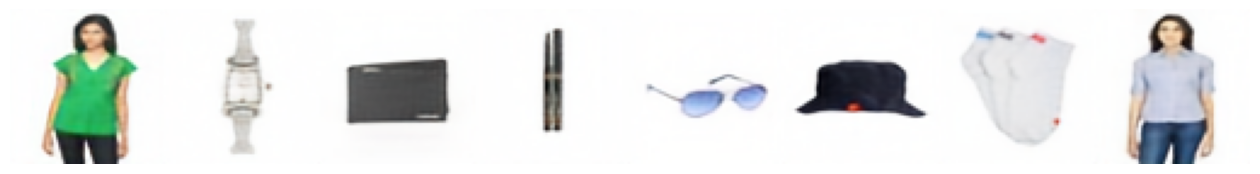

In [21]:
# view reconstructed images
log_images()
# save checkpoint
save_checkpoint("diffusion_vae")